In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

## Description

Checking impacts of hop depth (TODO: and number of paths between two nodes)
- Observing slope of effective delay vs measured delay
- Observing regressed synaptic delay

## Comparison of hop depth

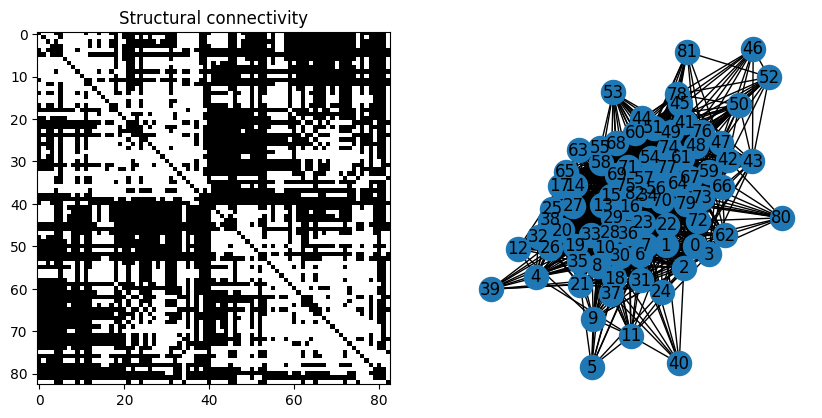

In [2]:
path_to_data = "../resources"

# Could be 50, 100, 200, 400
delay_max = 400
path_to_ftract = f"../../atlas_data/F-TRACT-090624/{delay_max}"

filename = "bundle_probability_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))

adj = adj[:83, :83]
adj -= np.diag(np.diag(adj))

bundle_prob_thresh = 0.9

adj = (adj > bundle_prob_thresh).copy()

bundle_prob = utils.load(op.join(path_to_data, "bundle_probability_atlas.pkl"))
bundle_prob = bundle_prob[:83, :83]
bundle_prob -= np.diag(np.diag(bundle_prob))
ftract_prob = utils.load(op.join(path_to_data, "adj_probability_ftract.pkl"))
ftract_prob = ftract_prob[:83, :83]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

In [3]:
with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

prob_thresh = 0
y_ground_mat *= ftract_prob > prob_thresh
y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

### Depth variation

Depth 1

In [22]:
max_path_depth = 1

a = 0.8

design_shortest = regmod.build_design_shortest(adj, n_subopt=max_path_depth, alpha=a)
design_model = solver.torch.tensor(design_shortest)

In [23]:
## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=0,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
utils.save(f"../resources/regressed_delays/depth{max_path_depth}-delays-bthresh{bundle_prob_thresh}-fthresh{0}.pkl", x_opt)

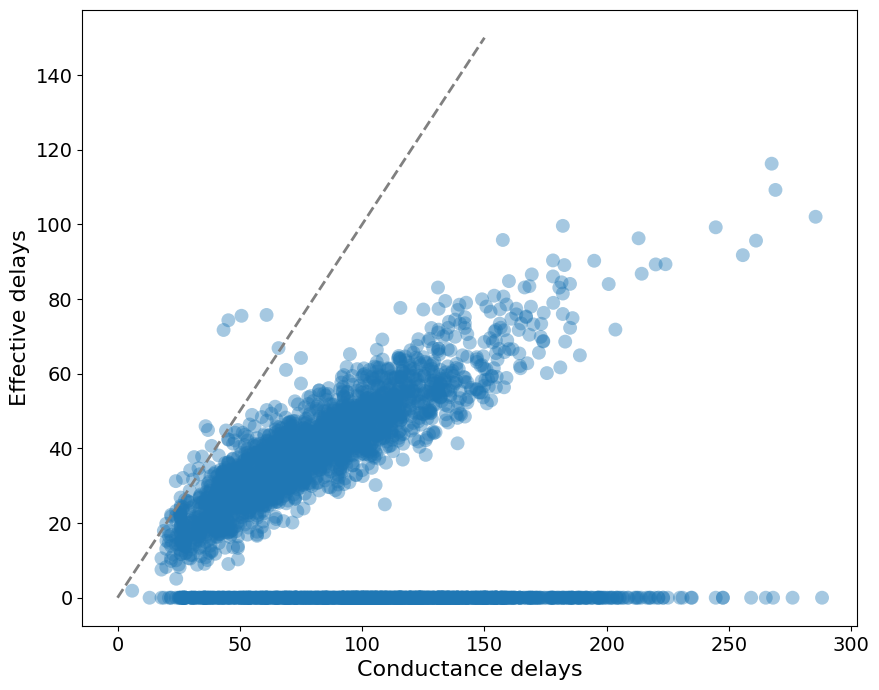

In [25]:
x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none")
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,150), np.linspace(0,150), linestyle='--', color="gray", linewidth=2)

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
# ax.legend(["Non-zero"], fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

Depth 2

In [14]:
max_path_depth = 2

a = 0.8

design_shortest = regmod.build_design_shortest(adj, n_subopt=max_path_depth, alpha=a)
design_model = solver.torch.tensor(design_shortest)

In [16]:
## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=0,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
utils.save(f"../resources/regressed_delays/depth{max_path_depth}-delays-bthresh{bundle_prob_thresh}-fthresh{0}.pkl", x_opt)

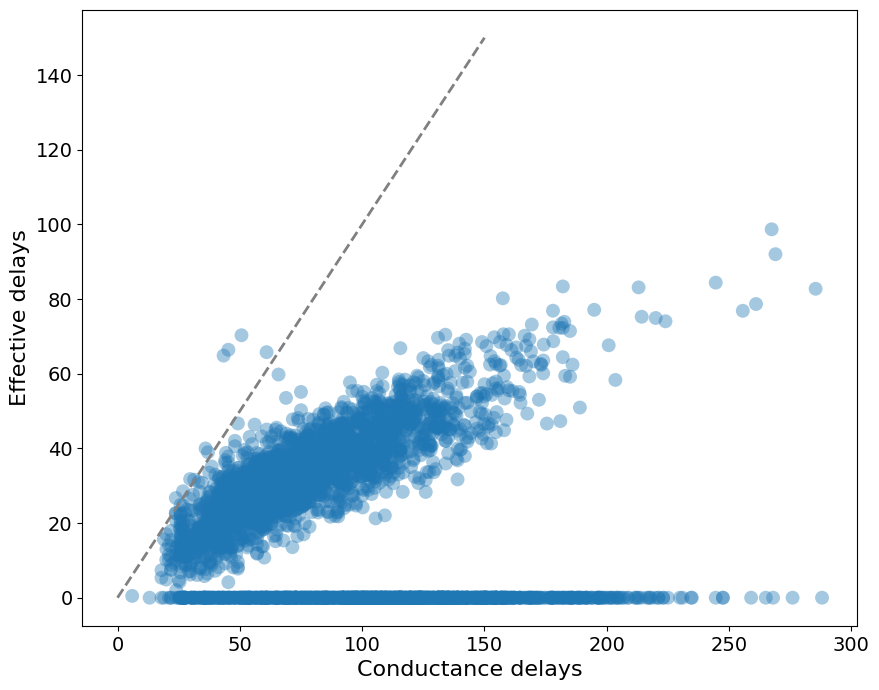

In [17]:
x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none")
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,150), np.linspace(0,150), linestyle='--', color="gray", linewidth=2)

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
# ax.legend(["Non-zero"], fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

### Overlap plot depth 1-2

In [26]:
x_opt1 = utils.load(f"../resources/regressed_delays/depth1-delays-bthresh{bundle_prob_thresh}-fthresh{0}.pkl")
x_opt2 = utils.load(f"../resources/regressed_delays/depth2-delays-bthresh{bundle_prob_thresh}-fthresh{0}.pkl")

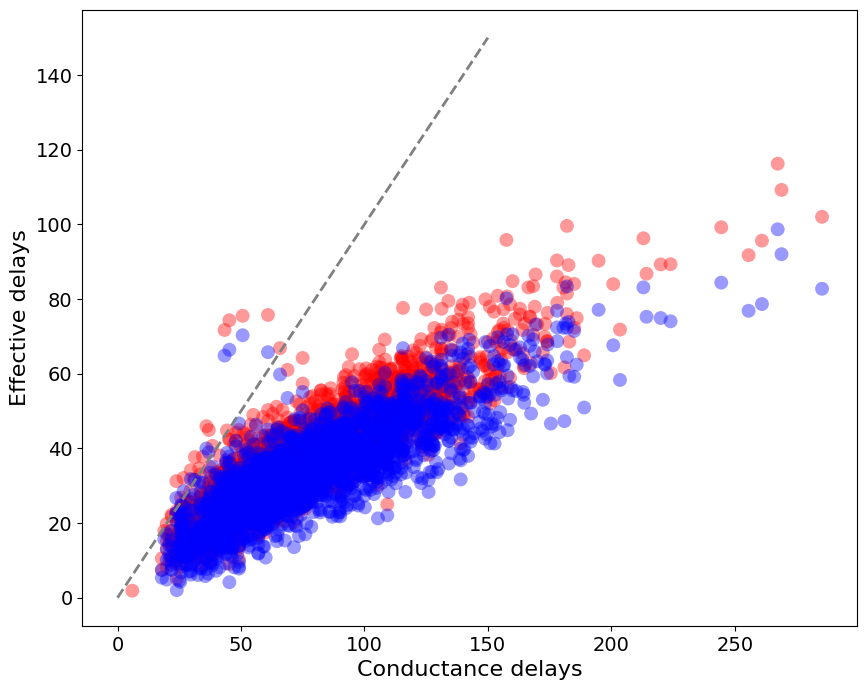

In [103]:
y = y_ground

x_mask1 = x_opt1 > 1
x_mask2 = x_opt2 > 1
y_mask = y != 0
xy_mask1 = np.logical_and(x_mask1, y_mask).numpy().astype(bool)
xy_mask2 = np.logical_and(x_mask2, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.scatter(y[xy_mask1], x_opt1[xy_mask1], s=100, alpha=.4, edgecolors="none", color='red')
ax.scatter(y[xy_mask2], x_opt2[xy_mask2], s=100, alpha=.4, edgecolors="none", color='blue')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,150), np.linspace(0,150), linestyle='--', color="gray", linewidth=2)

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero"], fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

In [104]:
nb_bins = 16
bins = np.linspace(10, 210, nb_bins + 1)
bins_center = (bins[:-1] + bins[1:]) /  2
avg1 = np.zeros(nb_bins)
avg2 = np.zeros(nb_bins)
for bidx in range(len(bins)-1):
    bin_flag1 = (bins[bidx] < y[xy_mask1]) & (y[xy_mask1] < bins[bidx+1])
    bin_flag2 = (bins[bidx] < y[xy_mask2]) & (y[xy_mask2] < bins[bidx+1])
    
    avg1[bidx] = x_opt1[xy_mask1][bin_flag1].mean()
    avg2[bidx] = x_opt2[xy_mask2][bin_flag2].mean()

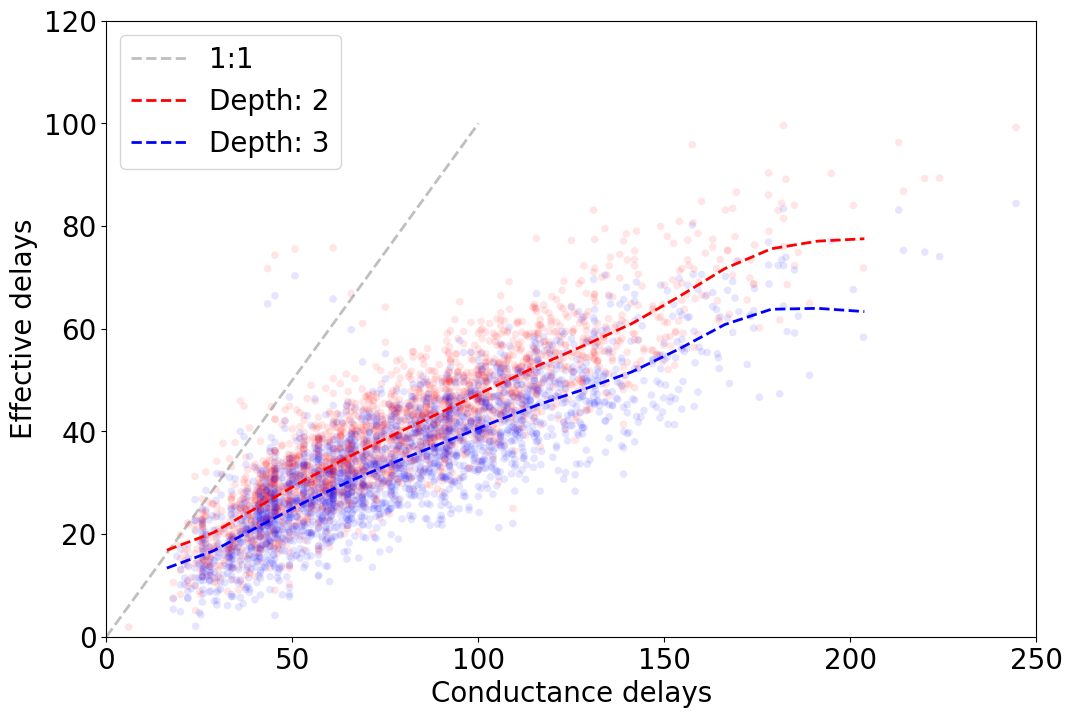

In [106]:
y = y_ground

x_mask1 = x_opt1 > 1
x_mask2 = x_opt2 > 1
y_mask = y != 0
xy_mask1 = np.logical_and(x_mask1, y_mask).numpy().astype(bool)
xy_mask2 = np.logical_and(x_mask2, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(y[xy_mask1], x_opt1[xy_mask1], s=30, alpha=.1, 
           edgecolors="none", color='red')
ax.scatter(y[xy_mask2], x_opt2[xy_mask2], s=30, alpha=.1, 
           edgecolors="none", color='blue')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,100), np.linspace(0,100), linestyle='--', 
        color="gray", linewidth=2, alpha=0.5, label="1:1")

ksize = 1
ax.plot(bins_center, gaussian_filter1d(avg1, ksize), linestyle='--', 
        color="red", linewidth=2, label='Depth: 2')
ax.plot(bins_center, gaussian_filter1d(avg2, ksize), linestyle='--', 
        color="blue", linewidth=2, label='Depth: 3')

ax.set_xlim(0, 250)
ax.set_ylim(0, 120)
ax.set_xlabel("Conductance delays", fontsize=20)
ax.set_ylabel("Effective delays", fontsize=20)
ax.tick_params(labelsize=20)

ax.legend(fontsize=20)
# ax.legend(["Non-zero"], fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)